In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
  import pynumdiff
except:
  !pip install git+https://github.com/florisvb/PyNumDiff
  import pynumdiff

  Cloning https://github.com/florisvb/PyNumDiff to /tmp/pip-req-build-h40by0su
  Running command git clone --filter=blob:none --quiet https://github.com/florisvb/PyNumDiff /tmp/pip-req-build-h40by0su
  Resolved https://github.com/florisvb/PyNumDiff to commit 842f2232f9a5805a4cdcc79ed7024980a774ada5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pynumdiff: filename=pynumdiff-0.3.dev21+g842f2232f-py3-none-any.whl size=63647 sha256=010488868c7d03d2853b580b609a91bc126d89b0eecdc19f18527997291df2c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbo69t1c/wheels/d5/d2/d5/e088d09db33998cc8a03da8ed5da944b4512c71615c0dc9e72
Successfully built pynumdiff


In [3]:
try:
  import pysindy as ps
except:
  #!pip install git+https://github.com/dynamicslab/pysindy
  !pip install pysindy[miosr]
  import pysindy as ps

from packaging.version import Version
if Version(ps.__version__) < Version("2.0.0"):
  raise ValueError("pysindy version is: " + ps.__version__ + "This notebook uses syntax that requires pysindy 2.0 or greater.")
else:
  print("pysindy version is: " + ps.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.7 MB/s eta 0:00:00
pysindy version is: 2.0.0


In [4]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-0r1z73kr
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-0r1z73kr
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=3ebc427dda495ef83d306a621fea0c41eaade57a945967751c0b01f8e8bc5bba
  Stored in directory: /tmp/pip-ephem-wheel-cache-znsaloxw/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')

pysindy_utility = import_local_or_github('pysindy_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now we will not include k as a static state. Instead, we will be using SINDy to find all the parameter values, which includes k.

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[lightblue]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[lightblue]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} + \bbox[lightblue]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Download, load, clean, and apply noise to data

In [6]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...
Number of trajectories: 
3001
Number of good trajectories: 
2924


# Compute naive numerical derivatives

Note: pysindy can do this for you, but because we have multiple distinct trajectories it is better if we do it externally. Also, that way we can see the derivatives and make sure they are good.

There are many ways to do this. Here we use the Savitzky Golay filter, which is a frequency domain sliding polynomial fit.

Don't over smooth as that will introduce artificial dynamics.

We will calculate the derivatives and save them into each trajectory for access later.

In [7]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
control_names = ['j1', 'j2']

In [8]:
for i, traj in enumerate(traj_list):
    for state in state_names:
        state_smooth, ddt_state = pynumdiff.savgoldiff(traj[state], 0.1, degree=3, window_size=5, smoothing_win=5)
        traj['ddt_' + state] = ddt_state
    traj_list[i] = traj

### Plot some of the derivatives

Compare the numerical derivative of states with the available states we have. For example, compare the numerical derivative of x with the measurement we have of x. We cannot do this for x_dot, however, since we do not have a measurement of x_ddot.

Make sure you are not getting over fitting.

<Axes: xlabel='Time', ylabel='x_dot'>

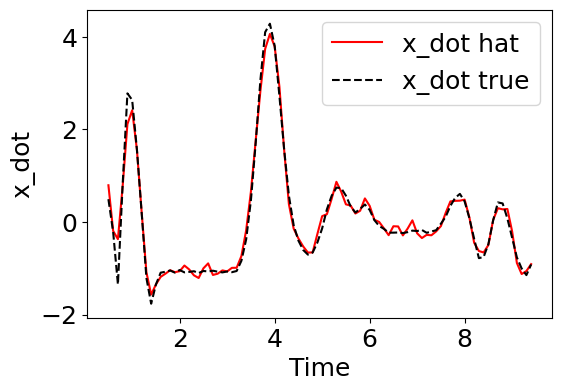

In [9]:
plot_tme(traj.time, traj['x_dot'], None, traj['ddt_x'], label_var='x_dot')

<Axes: xlabel='Time', ylabel='theta_dot'>

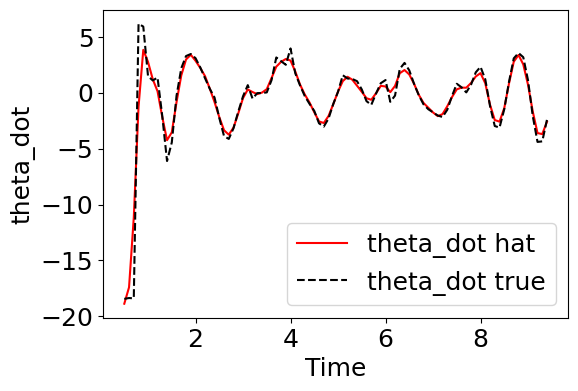

In [10]:
plot_tme(traj.time, traj['theta_dot'], None, traj['ddt_theta'], label_var='theta_dot')

<Axes: xlabel='Time', ylabel='z_dot'>

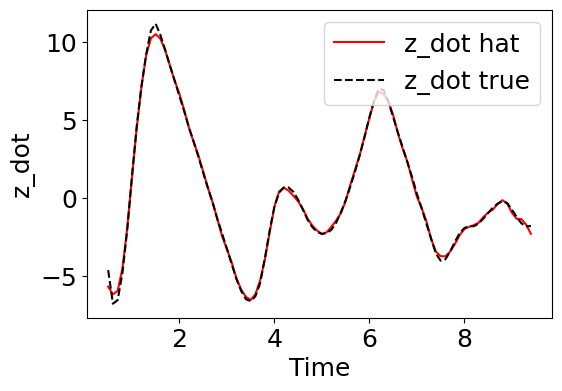

In [11]:
plot_tme(traj.time, traj['z_dot'], None, traj['ddt_z'], label_var='z_dot')

# Merge all trajectories

And extract the states, controls, and state derivatives.

In [12]:
traj_all = pd.concat(traj_list, ignore_index=True)

In [13]:
# extract states and controls
X = traj_all[state_names].values
U = traj_all[control_names].values

# extract derivatives
X_dot = traj_all[['ddt_' + state for state in state_names]].values

# Make a fake time base

pysindy expects continuously increasing timestamps, but our trajectories all have their own time bases. Since we calculated our own derivatives this does not pose an issue for pysindy.

In [14]:
dt = np.mean(np.diff(traj.time))
fake_time = np.arange(0, X.shape[0]*dt, dt)

# Build a SINDy model

### Build a bespoke feature library

We can inject some knowledge here, for example:
  * let's use $\sin(\theta)$ and $\cos(\theta)$, but not include $\theta$ on its own
  * to make the library usable with default optimizer licenses, we can restrict it so we only try products of $j_{1,2}$ with $\sin(\theta)$ and $\cos(\theta)$ and not the other variables

In [15]:
# First order polynomial library
poly_library = ps.PolynomialLibrary(degree=1)

# First order polynomial library -- we will use this to only extract the controls
# Don't include a bias (a constant) because the first library already has it
poly_library_ctrl = ps.PolynomialLibrary(degree=1, include_bias=False)

# Custom library that includes sin and cos of variable
# Don't include a bias (a constant) because the first library already has it
library_functions = [lambda x: np.sin( x ), lambda x: np.cos(x)]
library_function_names = [
    lambda x: "sin(" + x + ")",
    lambda x: "cos(" + x + ")",
]
sin_cos_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
sin_cos_library.library_functions = library_functions
sin_cos_library.function_names = library_function_names

# Initialize the default inputs, i.e. each library
# uses all the input variables, (6 states and 2 controls = 8 inputs and 2 libraries here)

# I think this is psindy v 1.0 syntax?
#inputs_temp = np.tile([0, 1, 2, 3, 4, 5, 6, 7], 3)
#inputs_per_library = np.reshape(inputs_temp, (3, 8))

# but this is v. 2.0 syntax
inputs_per_library = [[1,2,3,4,5], [6,7], [0]]

# Tensor the control library and the sin, cos library together
tensor_array = [[0, 1, 1],]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, poly_library_ctrl, sin_cos_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

### Print out the library.. for some reason you have to fit it first

Here we use the default sequentially thresholded least squares optimizer (which does not do a good job).

In [16]:
# Set up optimizer and model
optimizer = ps.optimizers.STLSQ()
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=fake_time,
          x_dot=X_dot,
          u=U,
          feature_names=state_names + control_names)

model.get_feature_names()

#model.print()

['1',
 'theta_dot',
 'x',
 'x_dot',
 'z',
 'z_dot',
 'j1',
 'j2',
 'sin(theta)',
 'cos(theta)',
 'j1 sin(theta)',
 'j1 cos(theta)',
 'j2 sin(theta)',
 'j2 cos(theta)']

### Now run with MIO optimizer

Mixed Integer Optimization allows for a strict sparsity target that will really pare down the total terms that are left.

Notice how we have some junk terms, but the structure overall looks pretty good.

In [17]:
# Set up optimizer and model
optimizer = ps.optimizers.MIOSR(target_sparsity=9)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=fake_time,
          x_dot=X_dot,
          u=U,
          feature_names=state_names + control_names)

Restricted license - for non-production use only - expires 2026-11-23


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=GeneralizedLibrary(inputs_per_library=[[1, 2, 3, 4, 5],
                                                             [6, 7], [0]],
                                         libraries=[PolynomialLibrary(degree=1),
                                                    PolynomialLibrary(degree=1,
                                                                      include_bias=False),
                                                    CustomLibrary(function_names=[<function <lambda> at 0x78900a1b32e0>,
                                                                                  <function <lambda> at 0x78900a1b3380>],
                                                                  library_functions=[<function <lambda> at 0x78900a1b31a0>,
                                                                                     <function <lambda> at 0x78900a1b3240>])],
                                         tensor_array=[[0, 1, 1]]),
      optimizer=MIOSR(target_sparsity=9))

In [18]:
model.print()

(theta)' = 0.814 theta_dot
(theta_dot)' = 1.573 theta_dot + 15.407 j1 + -7.063 sin(theta)
(x)' = 0.982 x_dot
(x_dot)' = -0.939 j2 sin(theta)
(z)' = 0.985 z_dot
(z_dot)' = -9.275 1 + 0.947 j2 cos(theta)


# Compile the model and save it

See `pysindy_fast_inference.ipynb` for break down of code.

In [19]:
theta, theta_dot, x, x_dot, z, z_dot, j1, j2 = sp.symbols('theta, theta_dot, x, x_dot, z, z_dot, j1, j2')
symbols = [theta, theta_dot, x, x_dot, z, z_dot, j1, j2]

In [20]:
lambda_funcs = pysindy_utility.build_lambda_funcs(model.get_feature_names(), symbols)

In [21]:
sindy_inference_model = pysindy_utility.SINDY_INFERENCE_MODEL(lambda_funcs, model.coefficients())

In [24]:
pysindy_utility.save_sindy_portable(lambda_funcs, model.coefficients(), 'sindy_dynamics_model.json')

# Evaluate model

### Compare predicted derivatives to true derivatives

Make a true vs predicted plot for each state. Note that this is cheating -- you would not have access to this if all you had was real data.

In [26]:
# Get the real dynamics function
f = planar_drone.F(k=1).f

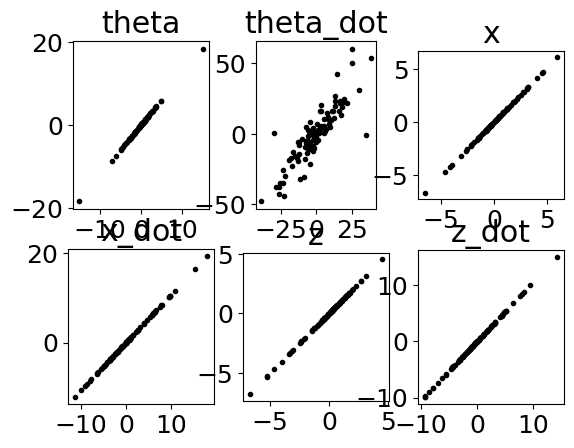

In [28]:
fig = plt.figure()

# pysindy inference is slow, so don't run on all of the data we have, just a subset is enough to get a sense.
N_points = 1000

for s in range(6):
  ax = fig.add_subplot(2,3,s+1)
  ax.set_aspect('equal')

  for k in range(0, N_points, 10):

    sindy_xdot = sindy_inference_model.predict(X[k:k+1,:], U[k:k+1,:])
    true_xdot = f(X[k,:], U[k,:])

    ax.plot(sindy_xdot[s], true_xdot[s], '.', color='black')
    ax.set_title(state_names[s])

### Compare predicted derivatives to naive numerical derivatives

This is feasible in real life. You can numerically differentiate the data and compare the the SINDy model predictions.

As expected, the 2nd derivatives are not great.

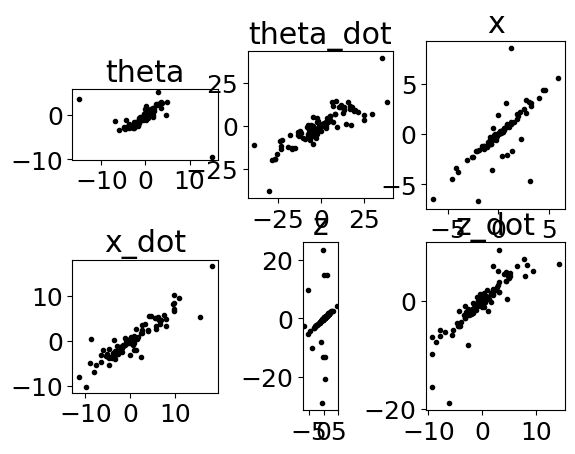

In [29]:
fig = plt.figure()

for s in range(6):
  ax = fig.add_subplot(2,3,s+1)
  ax.set_aspect('equal')

  _, ddt_state = pynumdiff.savgoldiff(X[:,s], dt, degree=3, window_size=9, smoothing_win=9)

  for k in range(0, N_points, 10):

    sindy_xdot = sindy_inference_model.predict(X[k:k+1,:], U[k:k+1,:])

    ax.plot(sindy_xdot[s], ddt_state[k], '.', color='black')
    ax.set_title(state_names[s])

# Exercises:

1. Try some of the other optimizers in pysindy:
  * STLSQ
  * SSR
2. Make the SINDy library more exhaustive
  * Note: to use MIOSR with a bigger library you will need to register for a gurobipy license (free for academic email on academic network).